# Análise Exploratória dos Dados - Competição "Talking Data"
## Alunos: Alessandro Rivello e Raul Guarini

Fazemos uma análise dos dados de teste e treinamento neste notebook. No caso do dados de treinamento, trabalhamos com uma amostra de 10% dos dados originais, frente ao tamanho do arquivo train.csv (quase 190 milhões de linhas!!!!!). O algoritmo para escolha da amostra está disponível no script ```row_select.py```.

Ambos datasets continham a coluna "click_time" com o timestamp do acesso no formato "YYYY-MM-DD hh:mm:ss". Para poder trabalhar os dados, utilizamos o comando ```sed``` no Terminal para:
1. Eliminar informação sobre o ano e o mês, em vista do fato de que todos os dados se encontram numa janela de apenas quatro dias. Isto torna o dataset mais leve e mais fácil de ser manipulado;
2. Colocar as colunas de dias, horas, minutos e segundos separadamente, facilitando também a análise.

No caso dos dados de teste, por exemplo, o comando utilizado foi: 
```
cat test.csv | sed 's/2017-11-//g' | sed -E -e 's/[[:space:]]/,/g' -e 's/:/,/g' -e 's/click_time/days,hours,minutes,seconds/g' > test_timed.csv

```

Também julgamos desnecessária a coluna "attributed_time". É um timestamp do horário em que o download foi feito. Como veremos, ela aporta pouca informação pois o dataset é amplamente desbalanceado, com muito poucos downloads afetivos. Além disso, este dado é gerado após o download ser feito, o que o torna incompatível com a tarefa de prever se o download ocorrerá ou não. Portanto, os dados utilizados estão disponíveis nos arquivos ```10_train_timed.csv``` e ```test_timed.csv```.

### Importando os dados

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns

# Definindo o estilo dos plots
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

path_raul = '/Users/Raul/Desktop/'

In [2]:
# Definir os datatypes antes da importação otimiza o uso de memória pelo Pandas.
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'days'          : 'uint8',
        'hours'         : 'uint8',
        'minutes'       : 'uint8',
        'seconds'       : 'uint8',
        }

In [3]:
# Forçando o Pandas a ler as mesmas colunas, sem necessidade de ler click_time e nem click_id na análise exploratória.
cols_train = ['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'days', 'hours', 'minutes', 'seconds']
cols_test = ['ip', 'app', 'device', 'os', 'channel', 'days', 'hours', 'minutes', 'seconds']

In [4]:
train = pd.read_csv(path_raul + '10_train_timed.csv', dtype = dtypes, usecols = cols_train)
test = pd.read_csv(path_raul + 'test_timed.csv', dtype = dtypes, usecols = cols_test)

In [5]:
train.head()

,ip,app,device,os,channel,is_attributed,days,hours,minutes,seconds
0,103022,3,1,23,379,0,6,14,37,44
1,1114221,3,1,19,379,0,6,14,37,59
2,247902,3,1,17,379,0,6,14,48,7
3,323550,3,1,13,379,0,6,14,53,39
4,484644,3,1,19,379,0,6,14,56,49


In [6]:
test.head()

,ip,app,device,os,channel,days,hours,minutes,seconds
0,5744,9,1,3,107,10,4,0,0
1,119901,9,1,3,466,10,4,0,0
2,72287,21,1,19,128,10,4,0,0
3,78477,15,1,13,111,10,4,0,0
4,123080,12,1,13,328,10,4,0,0


### Tempo
Vamos utilizar dados de timestamp primeiramente para entender o aspecto temporal. O quão dispersos ao longo dos dias são os cliques?

In [7]:
day_hour_train = train[['days', 'hours']].drop_duplicates().groupby('days').count()
day_hour_test = test[['days', 'hours']].drop_duplicates().groupby('days').count()

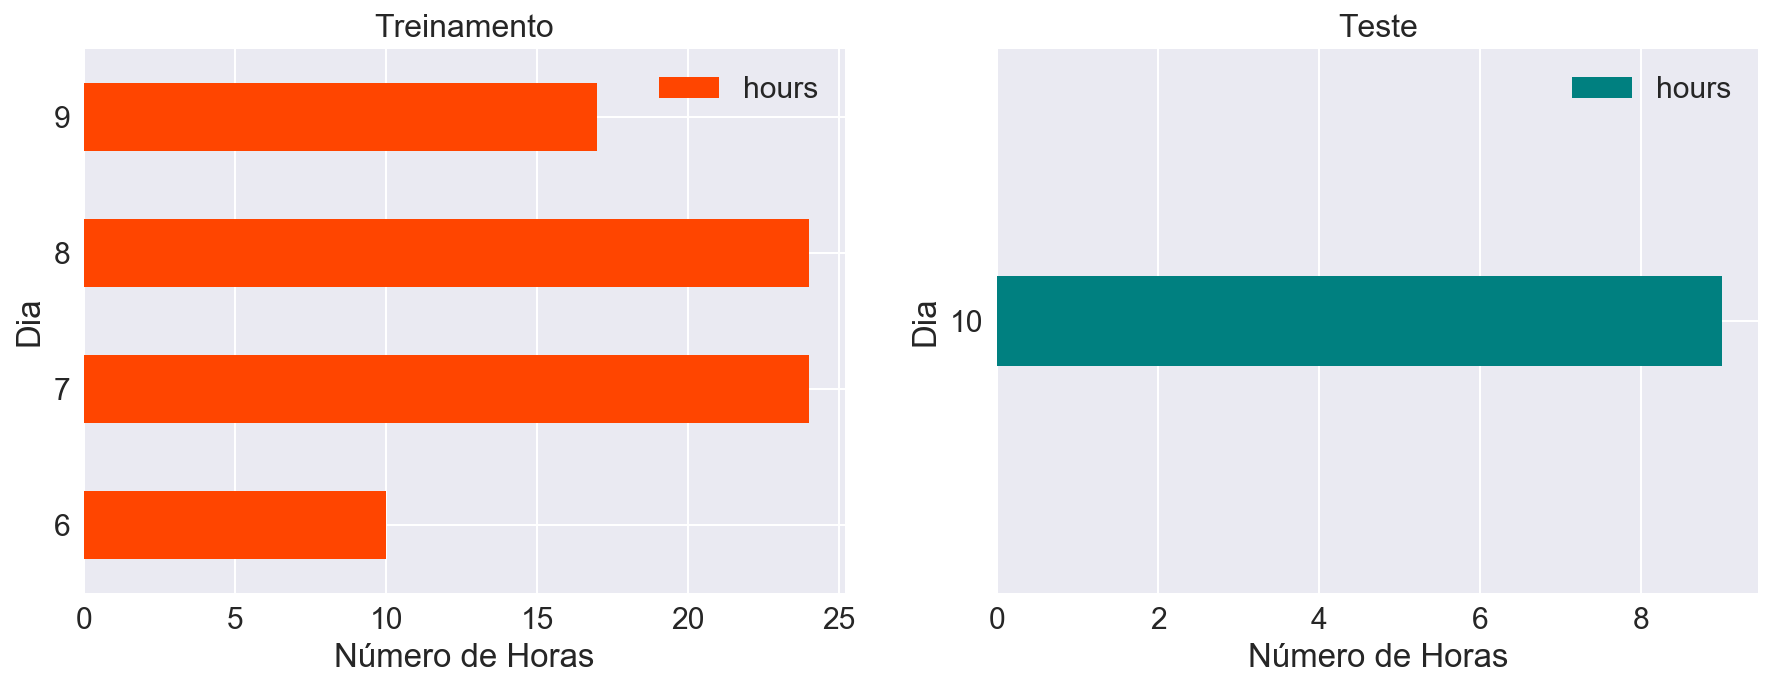

In [38]:
# Plotando os resultados acima
fig, (axs) = plt.subplots(1,2,figsize=(15,5))
day_hour_train.plot(kind = 'barh', ax = axs[0], title = 'Treinamento', 
                    color = 'orangered', width=0.5);
day_hour_test.plot(kind = 'barh', ax = axs[1], title = 'Teste', 
                   color = 'teal', width=0.1,);

axs[0].set_xlabel('Número de Horas');
axs[0].set_ylabel('Dia');
axs[0].title.set_size(16)

axs[1].set_xlabel('Número de Horas');
axs[1].set_ylabel('Dia');
axs[1].title.set_size(16)
sns.despine()

Vemos que os dados de treinamento compreendem os dias 6,7,8 e 9, ao passo que os dados de teste são somente do dia 10. Para os dias 7 e 8, temos observações em todas as horas. Para os dados de teste, temos observações em apenas 9 horas ao longo do dia. A próxima pergunta é: como se distribuem os clicks ao longo do dia?

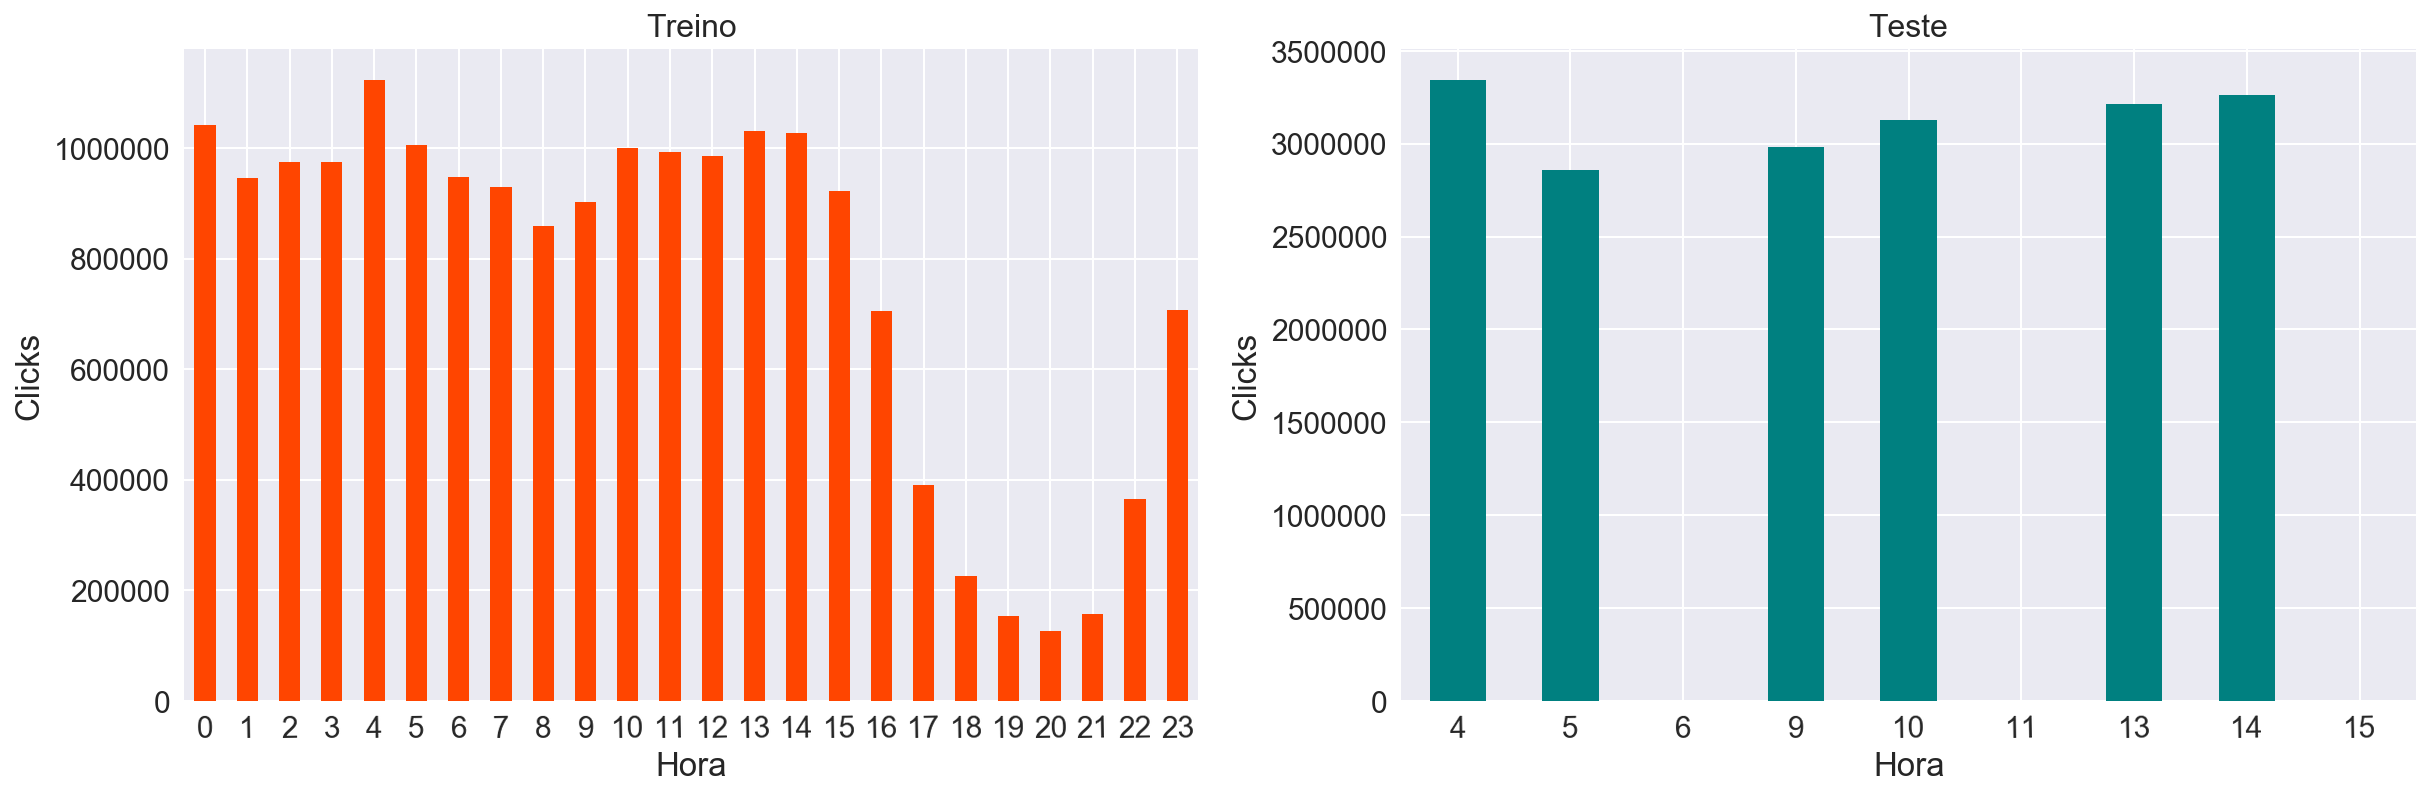

In [94]:
# Plotando número a dispersão de clicks ao longo do dia
fig, axs = plt.subplots(1,2, figsize = (20,6))

# Para os dados de treinamento:
train['hours'].value_counts(sort = False).plot(kind = 'bar', ax = axs[0], color = 'orangered',
                title = 'Treino');
axs[0].set_xlabel('Hora');
axs[0].set_ylabel('Clicks');
axs[0].tick_params(axis = 'x', labelrotation = 1)
axs[0].title.set_size(16)

#Para os dados de teste:
test['hours'].value_counts(sort = False).plot(kind = 'bar', ax = axs[1], color = 'teal',
                title = 'Teste');
axs[1].set_xlabel('Hora');
axs[1].set_ylabel('Clicks');
axs[1].tick_params(axis = 'x', labelrotation = 1)
axs[1].title.set_size(16)

In [34]:
test['hours'].value_counts(sort = False)

4     3344125
5     2858427
6         381
9     2984808
10    3127993
11        413
13    3212566
14    3261257
15        499
Name: hours, dtype: int64

Nos dados de treino, vemos que a maior parte dos clicks ocorreu do início da madrugada até o fim da tarde. A partir das 16hs, vemos um clara queda no número de cliques, potencialmente o momento em que as pessoas estavam indo de volta para casa ou indo dormir. Enfatizamos que os dias representados nos dados foram dias úteis, ao longo de uma mesma semana em Novembro de 2017. Curiosamente, após as 22hs, o número de cliques volta a subir.

No caso dos dados de teste, não há um padrão claro. Podemos identificar, contudo, que não há um número de cliques expressivos identificados nos dados às 6hs, 11hs e 15hs. Esta afirmação é confirmada pela simples contagem de cliques por hora feita acima. Como visto no gráfico anterior, os dados de teste são mais concentrados em alguns momentos ao longo dia se comparados aos dados de treinamento.

A próxima pergunta natural é de quantos desses downloads são convertidos efetivamente em downloads, no caso dos dados de treinamento.

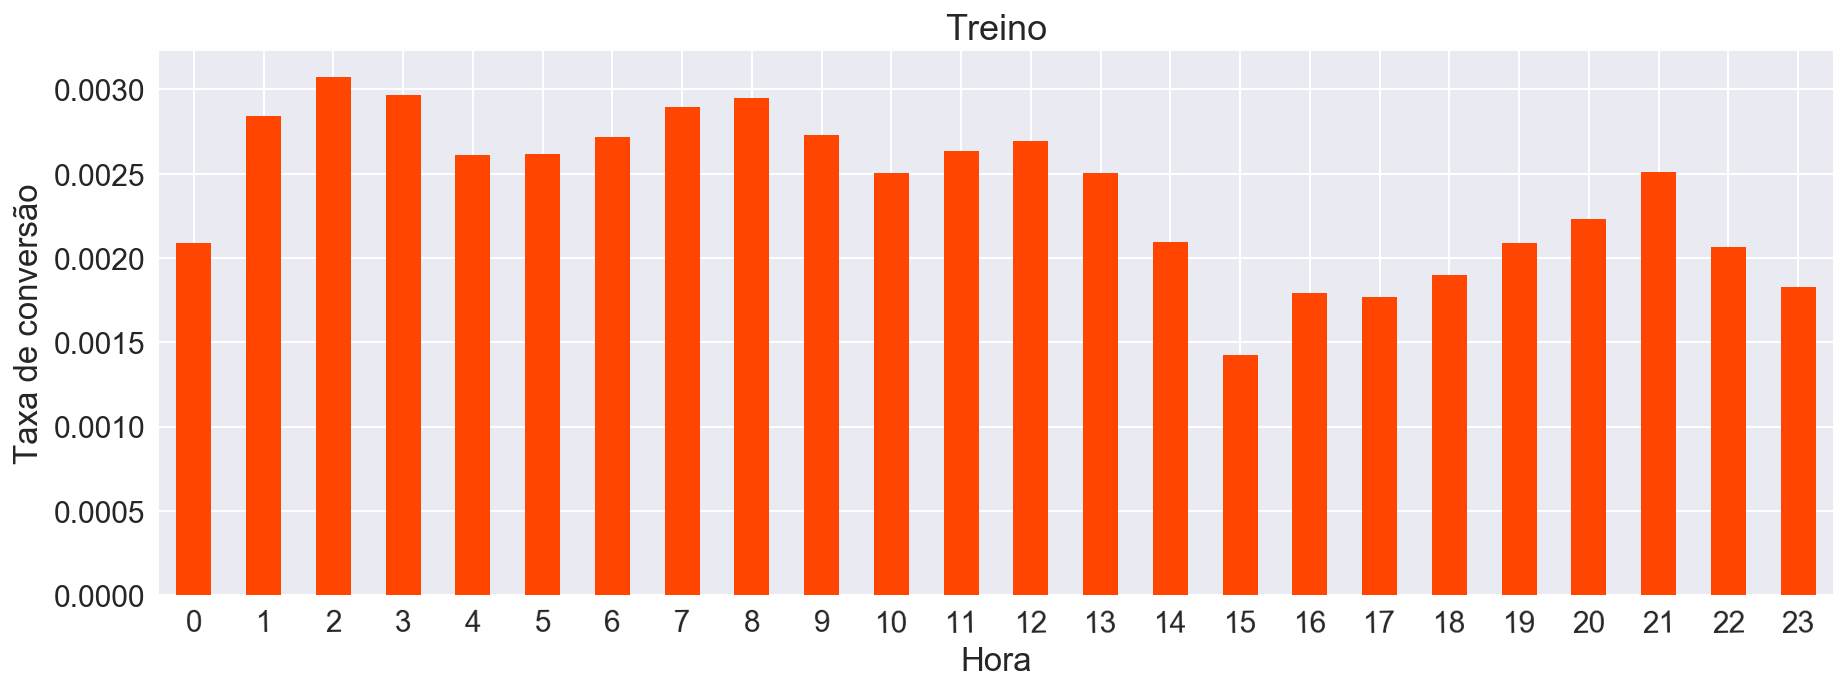

In [54]:
# Plotando a taxa de conversão dos cliques em download a cada hora
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1,1,1)
train[['hours', 'is_attributed']].groupby('hours').agg(np.mean).plot(kind = 'bar', color = 'orangered', 
                                                                   title = 'Treino', legend = None, ax = ax);
ax.set_xlabel('Hora');
ax.set_ylabel('Taxa de conversão - por hora')
ax.tick_params(axis = 'x', labelrotation = 1)

Notamos que a taxa de conversão ao longo do dia é consistentemente menor que 0.3%! Isto quer dizer que poucos downloads são, de fato, realizados e temos vários clicks em vão. As maiores taxas de conversão são encontradas durante a madrugada, enquanto as menores no meio da tarde.

Será que existe alguma tendência ao longo dos dias?

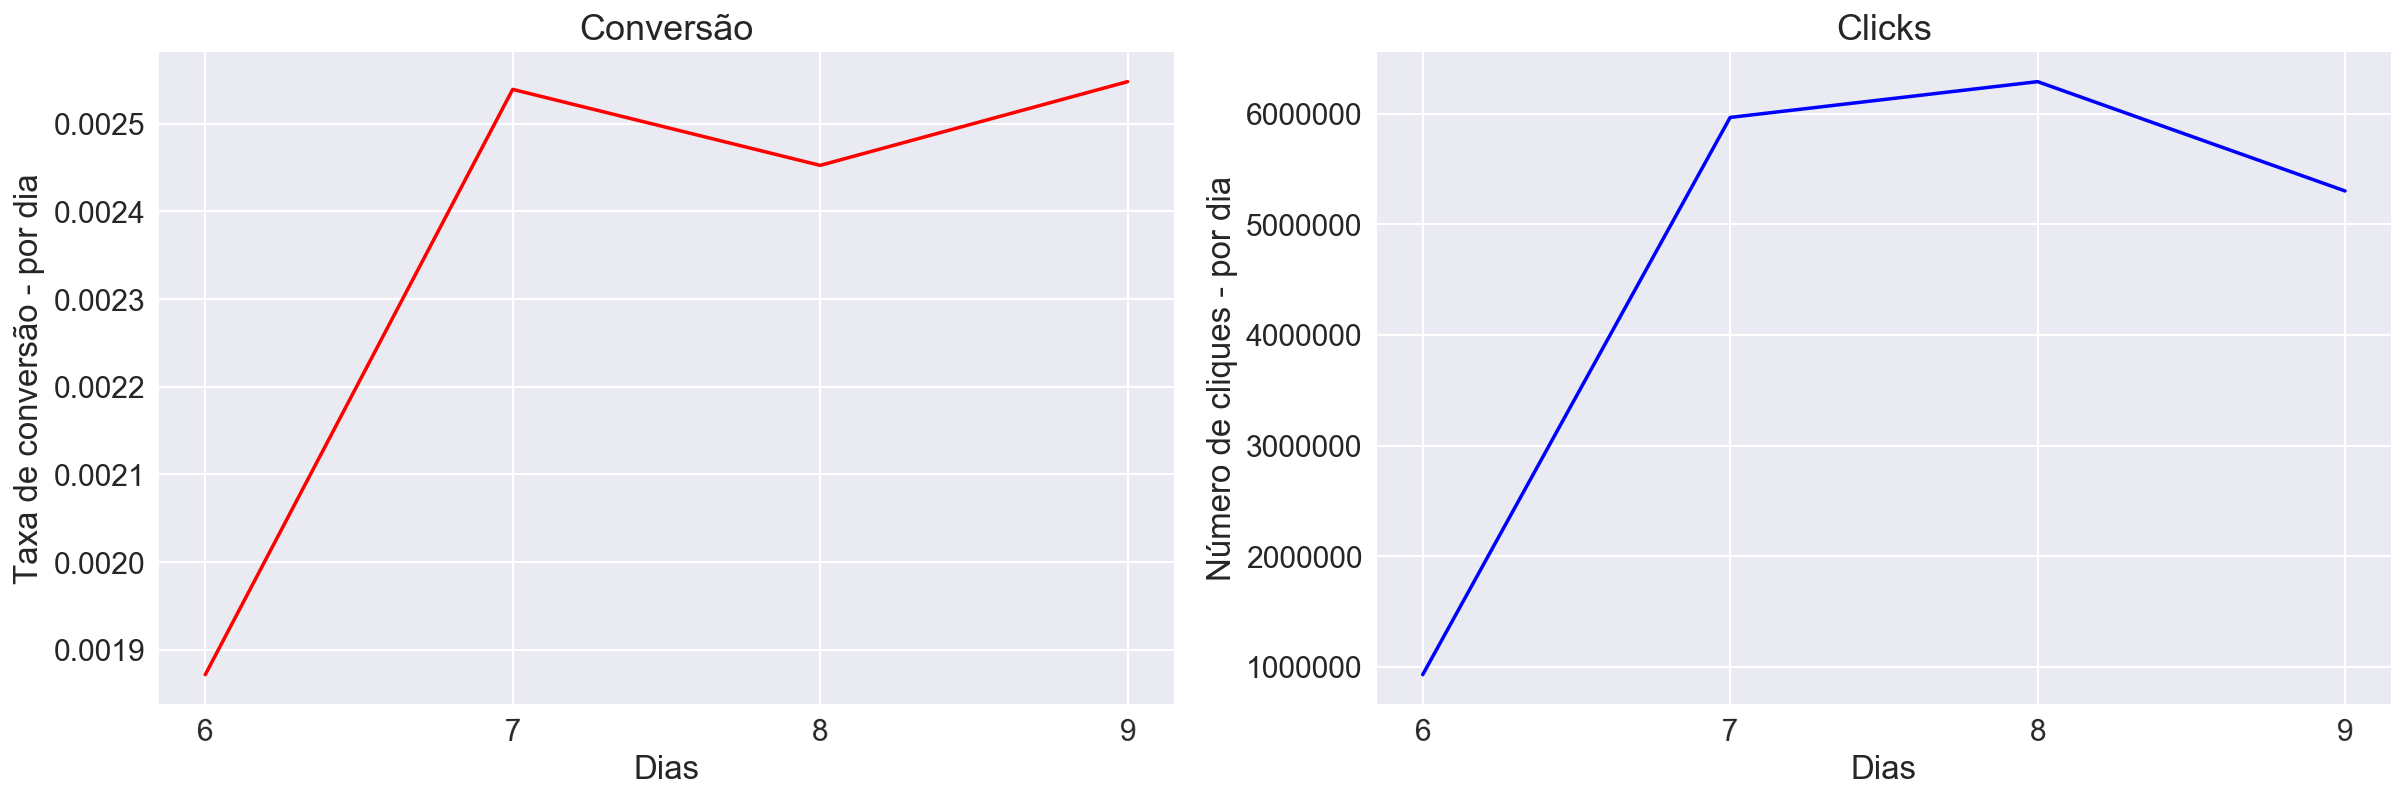

In [96]:
# Buscando uma tendência ao longo do tempo de cliques e downloads
fig, axs = plt.subplots(1,2, figsize = (20,6))
df = train[['days', 'is_attributed']].groupby('days').agg([np.mean, 'count'])
df.reset_index()
df['is_attributed']['mean'].plot(kind = 'line', color = 'red', ax = axs[0], title = 'Conversão', legend = None,
                                xticks = [6,7,8,9]);
df['is_attributed']['count'].plot(kind = 'line', color = 'blue', ax = axs[1], title = 'Clicks', legend = None,
                                 xticks = [6,7,8,9]);

axs[0].tick_params(axis = 'x', labelrotation = 1);
axs[0].set_ylabel('Taxa de conversão - por dia');
axs[0].set_xlabel('Dias');

axs[1].tick_params(axis = 'x', labelrotation = 1);
axs[1].set_ylabel('Número de cliques - por dia');
axs[1].set_xlabel('Dias');

Não há nenhum tipo de tendência visível ao longo dos quatro dias nos dados de treinamento. Podemos notar apenas que há muito menos dados para o dia 6 e que a taxa de conversão também foi menor nestes dias.

A baixa taxa de conversão sugere um dataset de treinamento desbalanceado, com relativamente poucas observações de fato contabilizadas como downloads.

In [104]:
# Checando se o dataset está realmente desbalanceado
df = train['is_attributed'].value_counts()
print('Número total de clicks: ' + str(df[0]))
print('Número total de downloads: ' + str(df[1]))
print('Razão dowloads/clicks: ' + str((df[1]/df[0])*100) +'%')

Número total de clicks: 18444556
Número total de downloads: 45832
Razão dowloads/clicks: 0.248485244101%


Aproximadamente apenas 1 click a cada 400 se converte em download!!! Isto deixa margem para acreditar que algum tipo de fraude esteja ocorrendo.

In [172]:
df = train[['ip','is_attributed', 'days', 'hours', 'minutes', 'seconds']].sort_values(by = ['days', 'hours', 'minutes', 'seconds'])
df['min_dif'] = df['minutes'] - df['minutes'].shift(1)
df['hour_dif'] = df['hours'] - df['hours'].shift(1)
df['s_dif'] = df['seconds'] - df['seconds'].shift(1)
df['day_dif'] = df['days'] - df['days'].shift(1)
# Calculando diferença de tempo entre clicks
df['total_dif'] = df['day_dif']*24*3600 + df['hour_dif']*3600 + df['min_dif']*60 + df['s_dif']

# Otimizando uso de memórias
#df.drop(['min_dif', 'hour_dif', 's_dif', 'hour_dif'], axis = 1, inplace = True)
gc.collect();

In [173]:
df[['is_attributed', 'total_dif']].groupby('is_attributed').agg(['mean', 'median', 'std']).head()

total_dif                 
                   mean median       std
is_attributed                           
0              0.014286    0.0  0.486502
1              0.014008    0.0  0.117523

A tabela acima mostra que a diferença média de tempo entre cliques é pequena, e virtualmente igual nos casos em que houve download e quando não houve. Contudo, a volatilidade no caso em que não foi feito o download é maior. O fato da mediana ser zero nos dois casos aponta que ao menos metade dos clicks em cada classe ocorreu no mesmo instante do tempo, evidenciando um fluxo abundante de dados na rede.